In [1]:
import nltk
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords 
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('reviews_full_v7.csv')
df.head()

,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,Genre,Text,Sentiment,Band_Genre,Combined_Genre
0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,technical thrash metal|math metal|progressive ...,I originally bought Chaosphere in late 2000......,0.9728,groove metal|thrash metal,technical thrash metal|math metal|progressive ...
1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,grindcore|melodic death metal,A midpoint between Carcass' early grind albums...,0.8479,grindcore|death metal,grindcore|melodic death metal
2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,symphonic power metal,"I'm not hard-core into metal at all, really, b...",0.9951,symphonic metal|power metal,symphonic power metal
3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,heavy metal|us power metal,"This is not a new album, but in fact, five alb...",0.9976,thrash metal|power metal,heavy metal|us power metal
4,Esoteric,July 16 2002,2002,7,A_Night_at_the_Opera,Blind_Guardian,70,https://www.metal-archives.com/reviews/Blind_G...,https://www.metal-archives.com/albums/Blind_Gu...,Somewhat Disappointing,power metal,I've been trying for months to come up with an...,0.5494,speed metal|power metal,power metal


In [3]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [4]:
tokenizer = nltk.RegexpTokenizer(r"\w+") # removes punctuation and special characters

### Based on https://doi.org/10.1155/2013/394758
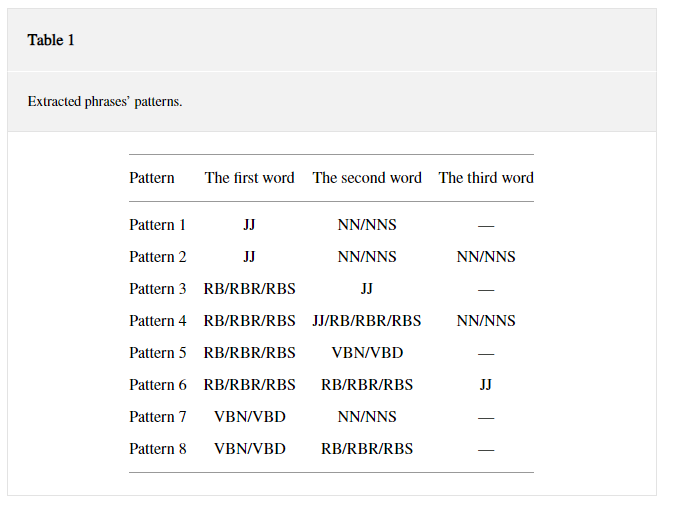

In [5]:
def isNoun(tag):
    return tag == 'NN' or tag == 'NNS'
    #return tag[:2] == 'NN'

def isAdverb(tag):
    return tag == 'RB' or tag == 'RBR' or tag == 'RBS'
    #return tag[:2] == 'RB'


def isVerb(tag):
    return tag == 'VBN' or tag == 'VBD'
    #return tag[:2] == 'VB'


def extract_features(sent):
    sent = list(sent)
    sent += [('NULL','NULL'), ('NULL','NULL')]
    all_features = []
    for i in range(len(sent)-2):
        word1, tag1 = sent[i]
        word2, tag2 = sent[i+1]
        word3, tag3 = sent[i+2]
        word1 = word1.lower()
        word2 = word2.lower()
        word3 = word3.lower()
        if tag1 == 'JJ':
            if isNoun(tag2):
                if isNoun(tag3):
                    all_features.append((word1, word2, word3)) #pattern 2
                else:
                    all_features.append((word1, word2)) #pattern 1
                    
        elif isAdverb(tag1):
            if tag2 == 'JJ':
                if isNoun(tag3):
                    all_features.append((word1, word2, word3)) #pattern 4
                else:
                    all_features.append((word1, word2)) #pattern 3
            elif isAdverb(tag2):
                if isNoun(tag3):
                    all_features.append((word1, word2, word3)) #pattern 4
                elif tag3 == 'JJ':
                    all_features.append((word1, word2, word3)) #pattern 6
            elif isVerb(tag2):
                all_features.append((word1, word2)) #pattern 5
        
        elif isVerb(tag1):
            if isNoun(tag2):
                all_features.append((word1, word2)) #pattern 7
            elif isAdverb(tag2):
                all_features.append((word1, word2)) #pattern 8
                
                
                
    return all_features

In [6]:
t1 = time.time()
all_features = {}

stop_words = set(stopwords.words('english')) 

for i,row in list(df.iterrows()):
    if i%5000 == 0:
        print(i,time.time()-t1)
    text = row['Text']
    sents = sent_tokenize(text)
    for sent in sents:
        tagged_sent = pos_tag([word for word in word_tokenize(sent) if word.isalnum() and len(word) > 1 and word not in stop_words])
        #print(tagged_sent)
        for phrase in extract_features(tagged_sent):
            feature = ' '.join(phrase)
            if feature in all_features:
                all_features[feature] += 1
            else:
                all_features[feature] = 1


0 5.661379337310791
5000 134.20748353004456
10000 266.545428276062
15000 412.7469766139984
20000 562.3275752067566
25000 717.8983035087585
30000 872.6892094612122
35000 1041.268667459488
40000 1221.7046661376953
45000 1431.0526504516602
50000 1635.9727458953857
55000 1854.4959907531738
60000 2067.7858159542084
65000 2301.2776448726654
70000 2523.268689393997
75000 2720.920462369919
80000 2905.80553483963
85000 3087.7009592056274
90000 3254.9663848876953


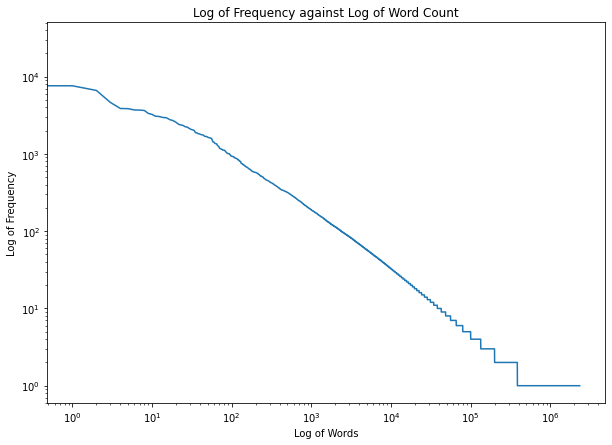

In [7]:
plt.title('Log of Frequency against Log of Word Count')
plt.ylabel('Log of Frequency')
plt.xlabel('Log of Words')
plt.loglog(sorted([all_features[key] for key in all_features],reverse = True))
plt.show()

In [8]:
mp = {k: v for k, v in sorted(all_features.items(), key=lambda item: item[1], reverse = True)}
print(len(mp))

2341710


In [9]:
phrases = pd.DataFrame()
phrases['Phrase'] = mp.keys()
phrases['Frequency'] = mp.values()
phrases.to_csv('opinions.csv', index = False)

In [10]:
import pickle

pickle.dump(mp,open('opinions.p','wb'))